In [18]:
import pandas as pd

# Load dataset
df = pd.read_csv("unified_dataset/dataset.csv")

# Preview distribution
print("Original label distribution:")
print(df['label'].value_counts())


Original label distribution:
label
7    20
4     8
3     8
6     7
5     6
1     2
2     1
Name: count, dtype: int64


In [21]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load dataset
df = pd.read_csv("unified_dataset/dataset.csv")
image_dir = "unified_dataset/images"
target_count = 20

# Data augmentation settings
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

augmented_rows = []
label_counts = df['label'].value_counts().to_dict()

# Augment each class up to 20 samples
for label in sorted(label_counts.keys()):
    current_count = label_counts[label]
    required = target_count - current_count

    if required <= 0:
        continue

    subset = df[df['label'] == label]
    print(f"🧪 Augmenting label {label}: need {required} more")

    generated = 0
    while generated < required:
        for idx, row in subset.iterrows():
            img_path = os.path.join(image_dir, row['image'])
            if not os.path.exists(img_path):
                print(f"❌ Missing: {img_path}")
                continue

            img = cv2.imread(img_path)
            if img is None:
                print(f"❌ Failed to read: {img_path}")
                continue

            img = cv2.resize(img, (224, 224))
            img = np.expand_dims(img, axis=0)

            gen = datagen.flow(img, batch_size=1) 
            aug_img = next(gen)[0].astype(np.uint8)
            new_filename = f"aug_label{label}_{idx}_{generated}.jpg"
            new_path = os.path.join(image_dir, new_filename)
            cv2.imwrite(new_path, aug_img)

            augmented_rows.append({'image': new_filename, 'label': label})
            generated += 1
            if generated >= required:
                break

# Add augmented data to original DataFrame
df_aug = pd.DataFrame(augmented_rows)
df_final = pd.concat([df, df_aug], ignore_index=True)
df_final.to_csv("unified_dataset/dataset_balanced.csv", index=False)

print("\n✅ Augmentation complete!")
print("📊 Final label distribution:")
print(df_final['label'].value_counts())


🧪 Augmenting label 1: need 18 more
🧪 Augmenting label 2: need 19 more
🧪 Augmenting label 3: need 12 more
🧪 Augmenting label 4: need 12 more
🧪 Augmenting label 5: need 14 more
🧪 Augmenting label 6: need 13 more

✅ Augmentation complete!
📊 Final label distribution:
label
7    20
5    20
4    20
3    20
6    20
2    20
1    20
Name: count, dtype: int64


In [22]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import cv2

# Load dataset
df = pd.read_csv("unified_dataset/dataset_final.csv")
image_dir = "unified_dataset/images"

# Load and preprocess images
X = []
y = []
for _, row in df.iterrows():
    img_path = os.path.join(image_dir, row['image'])
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, (224, 224))
        X.append(img)
        y.append(row['label'])

X = np.array(X, dtype='float32') / 255.0
y = to_categorical(np.array(y) - 1, num_classes=7)  # assuming labels are 1–7

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# === STEP 1: Load and preprocess data ===
df = pd.read_csv('unified_dataset/dataset_final.csv')  # your balanced CSV
image_dir = 'unified_dataset/images'
img_size = 224

X, y = [], []

for _, row in df.iterrows():
    img_path = os.path.join(image_dir, row['image'])
    img = cv2.imread(img_path)
    if img is None:
        print(f"❌ Skipping unreadable image: {img_path}")
        continue
    img = cv2.resize(img, (img_size, img_size))
    X.append(img)
    y.append(row['label'])

X = np.array(X) / 255.0  # normalize
y = np.array(y)
y_cat = to_categorical(y - 1, num_classes=7)  # Norwood stages 1-7 → 0-6

# === STEP 2: Split ===
X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y)

# === STEP 3: Data augmentation ===
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# === STEP 4: Build MobileNetV2 model ===
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0003),
              loss=CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

# === STEP 5: Train ===
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(datagen.flow(X_train, y_train, batch_size=16),
                    validation_data=(X_val, y_val),
                    epochs=20,
                    callbacks=[early_stop])

# === STEP 6: Save model ===
model.save('norwood_mobilenet_model.h5')
print("✅ Model saved to 'norwood_mobilenet_model.h5'")


c:\jay\envs\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 803ms/step - accuracy: 0.2075 - loss: 2.5454 - val_accuracy: 0.4286 - val_loss: 1.6117
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 533ms/step - accuracy: 0.2187 - loss: 2.0212 - val_accuracy: 0.6071 - val_loss: 1.3939
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 530ms/step - accuracy: 0.4900 - loss: 1.5627 - val_accuracy: 0.6071 - val_loss: 1.2657
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 544ms/step - accuracy: 0.5382 - loss: 1.4732 - val_accuracy: 0.6071 - val_loss: 1.1717
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 510ms/step - accuracy: 0.6273 - loss: 1.2607 - val_accuracy: 0.7500 - val_loss: 1.0874
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 510ms/step - accuracy: 0.6268 - loss: 1.2256 - val_accuracy: 0.8571 - val_loss: 0.9977
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 487ms/step - accuracy: 0.7180 - loss: 1.0394 - val_accuracy: 0.8214 - val_loss: 0.9467
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 527ms/step - accuracy: 0.8224 - loss: 0.9895 - val_accuracy: 0.7500 - val_loss

✅ Model saved to 'norwood_mobilenet_model.h5'


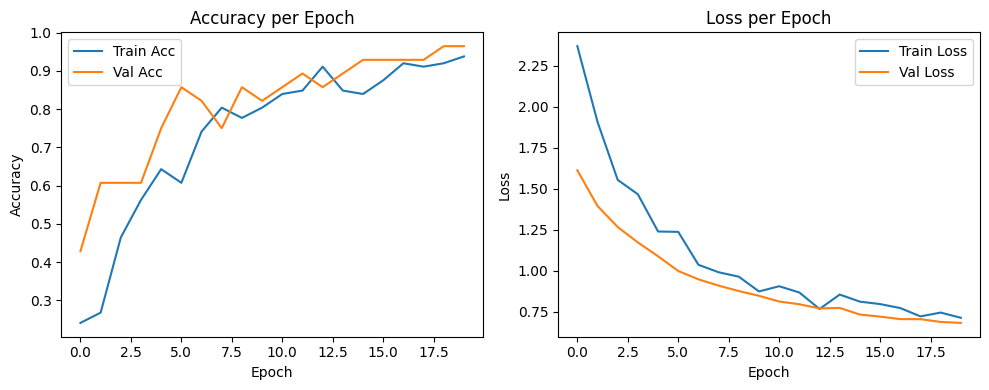

In [24]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [28]:
from tensorflow.keras.models import load_model

# Load model (if starting fresh)
model = load_model('norwood_mobilenet_model.h5')

# Custom image path
custom_img_path = 'test_set2.png' #with your actual path

# Preprocess image
img = cv2.imread(custom_img_path)
if img is None:
    raise ValueError(f"Could not read image: {custom_img_path}")
img = cv2.resize(img, (224, 224))
img = img / 255.0
img = np.expand_dims(img, axis=0)

# Predict
pred = model.predict(img)
predicted_class = np.argmax(pred) + 1  # Add +1 to match Norwood stages (1–7)

print(f"🧠 Predicted Norwood Stage: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
🧠 Predicted Norwood Stage: 3
